## Task 2 - CLIP Fine-Tuning on the Visual Encoder

In [1]:
#@title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch
print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

Python : 3.13.7 (main, Aug 15 2025, 12:34:02) [GCC 15.2.1 20250813]
CUDA   : 12.8
Torch  : 2.9.0+cu128
Device : NVIDIA GeForce RTX 4090
Tue Nov 11 05:00:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:1F:00.0 Off |                  Off |
| 33%   37C    P2             60W /  450W |   23706MiB /  24564MiB |      0%      Default |
|   

In [2]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel, logging
from peft import LoraConfig, get_peft_model, TaskType
from torchinfo import summary
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import warnings

/home/course/select/b10401006/tmp2/mai-hw2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# some settings
DEVICE = "cuda:3" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14" # pre-trained CLIP model (ViT-L/14)
BATCH_SIZE = 128 # adjust based on your GPU memory
gradient_accumulation_steps = 1 # adjust based on your GPU memory
# For Linear Probe & LoRA
NUM_EPOCHS = 1
print(f"Using device: {DEVICE}")

Using device: cuda:3


In [4]:
# CLIP settings
# --- Load CLIP Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)
# --- Define a transform to process images for CLIP ---
class CLIPTransform:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, image):
        # The processor expects a PIL image or list of images
        # It returns a dict, we extract 'pixel_values'
        # .squeeze(0) removes the batch dimension the processor adds
        return self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

clip_transform = CLIPTransform(processor)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
# dataset related imports
from torchvision.datasets import Flowers102 
from datasets import load_dataset

# --- Flowers102 ---
# prepare Flowers102 dataset
flowers102_train_dts = Flowers102(root="../", split="train", transform=clip_transform, download=True)
flowers102_val_dts = Flowers102(root="../", split="val", transform=clip_transform, download=True)
flowers102_test_dts = Flowers102(root="../", split="test", transform=clip_transform, download=True) # evaluation on this set

print(f"Total training samples: {len(flowers102_train_dts)}")
print(f"Total validation samples: {len(flowers102_val_dts)}")
print(f"Total test samples: {len(flowers102_test_dts)}") # should be 6149

# prepare class names for Flowers102
with open("cat_to_name.json", "r") as f:
    flowers102_cat_to_name = json.load(f)
# Convert to 0-indexed list (Flowers102 uses 1-indexed labels)
flowers102_class_names = [flowers102_cat_to_name[str(i+1)] for i in range(102)]
print(f"Number of Flowers102 classes: {len(flowers102_class_names)}")

# --- CUB-200-2011 ---
birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")

# Custom wrapper to apply CLIP transform to CUB dataset
class CUBDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Split train into train and validation (e.g., 90% train, 10% val)
cub_train_val = birds_200["train"]
train_size = int(0.9 * len(cub_train_val))
val_size = len(cub_train_val) - train_size
cub_train_split, cub_val_split = random_split(
    cub_train_val, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

cub_bird_train_dts = CUBDatasetWrapper(cub_train_split, clip_transform)
cub_bird_val_dts = CUBDatasetWrapper(cub_val_split, clip_transform)
cub_bird_test_dts = CUBDatasetWrapper(birds_200["test"], clip_transform)

print(f"Total training samples: {len(cub_bird_train_dts)}")
print(f"Total validation samples: {len(cub_bird_val_dts)}")
print(f"Total test samples: {len(cub_bird_test_dts)}") # should be 5794

cub_class_names = sorted(set(birds_200["train"].features["label"].names))
print(f"Number of CUB-200-2011 classes: {len(cub_class_names)}")

# === Create DataLoaders ===
# You can choose which dataset to work with
DATASET_NAME = "flowers102"  # or "cub200"

if DATASET_NAME == "flowers102":
    train_dts = flowers102_train_dts
    val_dts = flowers102_val_dts
    test_dts = flowers102_test_dts
    class_names = flowers102_class_names
    NUM_CLASSES = 102
elif DATASET_NAME == "cub200":
    train_dts = cub_bird_train_dts
    val_dts = cub_bird_val_dts
    test_dts = cub_bird_test_dts
    class_names = cub_class_names
    NUM_CLASSES = 200
else:
    raise ValueError("Unknown dataset")

train_loader = DataLoader(train_dts, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dts, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dts, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"\nUsing dataset: {DATASET_NAME}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Total training samples: 1020
Total validation samples: 1020
Total test samples: 6149
Number of Flowers102 classes: 102
Total training samples: 5394
Total validation samples: 600
Total test samples: 5794
Number of CUB-200-2011 classes: 200

Using dataset: flowers102
Number of classes: 102
Train batches: 8
Val batches: 8
Test batches: 49


--- Starting Method: Linear Probing ---


Epoch 1/1 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Epoch 1 - Train Loss: 4.5641 | Val Loss: 4.3893 | Val Acc: 15.88% | Time: 17.43 sec


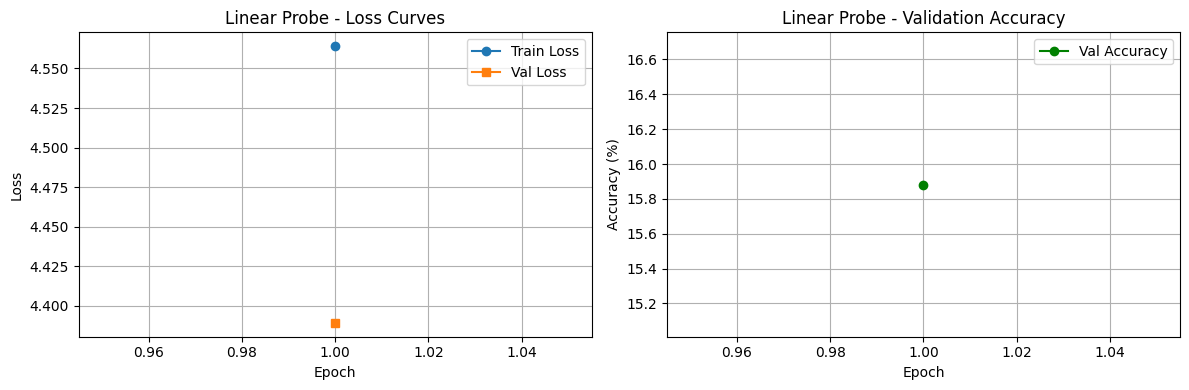

Testing: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]



Linear Probe Test Results:
Test Loss: 4.3964
Test Accuracy: 16.33%

Classification Report:
                           precision    recall  f1-score   support

            pink primrose       0.00      0.00      0.00        20
hard-leaved pocket orchid       0.00      0.00      0.00        40
         canterbury bells       0.06      0.70      0.12        20
                sweet pea       0.00      0.00      0.00        36
         english marigold       0.33      0.36      0.34        45
               tiger lily       0.00      0.00      0.00        25
              moon orchid       0.60      0.15      0.24        20
         bird of paradise       0.00      0.00      0.00        65
                monkshood       0.00      0.00      0.00        26
            globe thistle       0.11      0.04      0.06        25
               snapdragon       0.20      0.01      0.03        67
              colt's foot       0.24      0.73      0.36        67
              king protea       0.30

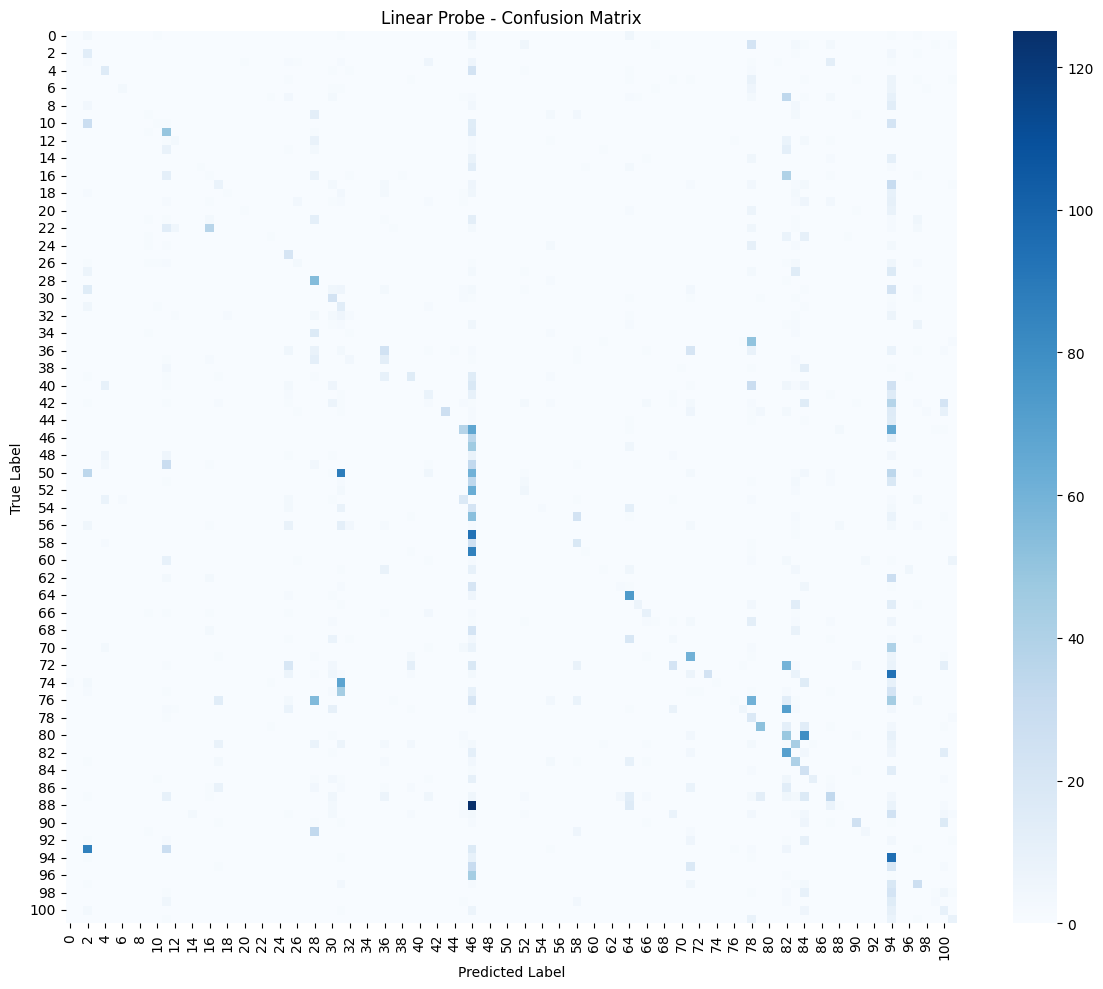


Model saved to linear_probe_flowers102.pt


In [6]:
print("--- Starting Method: Linear Probing ---")

# === 1. Load CLIP Vision Model (no text part) ===
clip_model = CLIPModel.from_pretrained(MODEL_ID)
vision_model = clip_model.vision_model
visual_projection = clip_model.visual_projection

vision_model.to(DEVICE)
visual_projection.to(DEVICE)

# === 2. Freeze backbone ===
for p in vision_model.parameters():
    p.requires_grad = False
for p in visual_projection.parameters():
    p.requires_grad = False

# === 3. Classifier head ===
# CLIP ViT-Large outputs 1024-dim embeddings after visual_projection
embedding_dim = visual_projection.out_features  # 768 for ViT-L
head = nn.Linear(embedding_dim, NUM_CLASSES).to(DEVICE)
    
# === 4. Training setup ===
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(head.parameters(), lr=lr)
train_losses, val_losses, val_accuracies = [], [], []

# === 5. Training Loop ===
import time

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    head.train()
    vision_model.eval()
    
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass through CLIP vision encoder
        with torch.no_grad():
            vision_outputs = vision_model(pixel_values=images)
            image_embeds = vision_outputs.last_hidden_state[:, 0, :]  # CLS token
            image_embeds = visual_projection(image_embeds)
        
        # Forward through classifier head
        logits = head(image_embeds)
        loss = criterion(logits, labels)
        
        # Backward pass with gradient accumulation
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * gradient_accumulation_steps
    
    # Handle remaining gradients
    if (batch_idx + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    head.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            vision_outputs = vision_model(pixel_values=images)
            image_embeds = vision_outputs.last_hidden_state[:, 0, :]
            image_embeds = visual_projection(image_embeds)
            
            logits = head(image_embeds)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)
    
    epoch_end = time.time()
    print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]*100:.2f}% | "
          f"Time: {epoch_end - epoch_start:.2f} sec")

# === 6. Plot curves ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, NUM_EPOCHS+1), val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Linear Probe - Loss Curves')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, NUM_EPOCHS+1), [acc*100 for acc in val_accuracies], label='Val Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Linear Probe - Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# === 7. Test ===
head.eval()
test_preds = []
test_labels = []
test_loss = 0.0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        vision_outputs = vision_model(pixel_values=images)
        image_embeds = vision_outputs.last_hidden_state[:, 0, :]
        image_embeds = visual_projection(image_embeds)
        
        logits = head(image_embeds)
        loss = criterion(logits, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(logits, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = (np.array(test_preds) == np.array(test_labels)).mean()
print(f"\nLinear Probe Test Results:")
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# === 8. Visualization ===
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', fmt='d', cbar=True)
plt.title('Linear Probe - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Save model
torch.save({
    'head_state_dict': head.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'test_accuracy': test_accuracy,
}, f'linear_probe_{DATASET_NAME}.pt')
print(f"\nModel saved to linear_probe_{DATASET_NAME}.pt")

In [10]:
print("--- Starting Method: LoRA Fine-Tuning ---")

# === 1. Load CLIP Vision Model (no text part) ===
clip_model = CLIPModel.from_pretrained(MODEL_ID)
vision_model = clip_model.vision_model
visual_projection = clip_model.visual_projection

# === 2. LoRA config (Q/V projections) ===
lora_config = LoraConfig(
    r=8,  # rank of the low-rank matrices
    lora_alpha=16,  # scaling factor
    target_modules=["q_proj", "v_proj"],  # apply LoRA to Q and V projections in attention
    lora_dropout=0.1,
    bias="none"
    # DO NOT use task_type for vision models - it causes issues with argument forwarding
)

# === 3. Wrap with PEFT ===
vision_model_lora = get_peft_model(vision_model, lora_config)
print("LoRA Model - Trainable Parameters:")
vision_model_lora.print_trainable_parameters()

vision_model_lora.to(DEVICE)
visual_projection.to(DEVICE)

# === 4. Freeze projection ===
for p in visual_projection.parameters():
    p.requires_grad = False

# === 5. Classifier head ===
embedding_dim = visual_projection.out_features
head = nn.Linear(embedding_dim, NUM_CLASSES).to(DEVICE)

# === 6. Training setup ===
lr = 1e-4  # Lower learning rate for LoRA fine-tuning
criterion = nn.CrossEntropyLoss()
# Optimize both LoRA parameters and classifier head
optimizer = torch.optim.Adam(
    list(vision_model_lora.parameters()) + list(head.parameters()), 
    lr=lr
)
train_losses, val_losses, val_accuracies = [], [], []

# === 7. Training Loop ===
import time

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    vision_model_lora.train()
    head.train()
    
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass through LoRA-enhanced CLIP vision encoder
        vision_outputs = vision_model_lora(pixel_values=images)
        image_embeds = vision_outputs.last_hidden_state[:, 0, :]  # CLS token
        
        # Project embeddings (frozen projection layer)
        with torch.no_grad():
            image_embeds = visual_projection(image_embeds)
        
        # Forward through classifier head
        logits = head(image_embeds)
        loss = criterion(logits, labels)
        
        # Backward pass with gradient accumulation
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * gradient_accumulation_steps
    
    # Handle remaining gradients
    if (batch_idx + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    vision_model_lora.eval()
    head.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            vision_outputs = vision_model_lora(pixel_values=images)
            image_embeds = vision_outputs.last_hidden_state[:, 0, :]
            image_embeds = visual_projection(image_embeds)
            
            logits = head(image_embeds)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)
    
    epoch_end = time.time()
    print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]*100:.2f}% | "
          f"Time: {epoch_end - epoch_start:.2f} sec")

# === 8. Plot curves ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, NUM_EPOCHS+1), val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LoRA Fine-Tuning - Loss Curves')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, NUM_EPOCHS+1), [acc*100 for acc in val_accuracies], label='Val Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LoRA Fine-Tuning - Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# === 9. Test ===
vision_model_lora.eval()
head.eval()
test_preds = []
test_labels = []
test_loss = 0.0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        vision_outputs = vision_model_lora(pixel_values=images)
        image_embeds = vision_outputs.last_hidden_state[:, 0, :]
        image_embeds = visual_projection(image_embeds)
        
        logits = head(image_embeds)
        loss = criterion(logits, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(logits, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = (np.array(test_preds) == np.array(test_labels)).mean()
print(f"\nLoRA Fine-Tuning Test Results:")
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# === 10. Visualization ===
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Greens', fmt='d', cbar=True)
plt.title('LoRA Fine-Tuning - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Save model
torch.save({
    'lora_state_dict': vision_model_lora.state_dict(),
    'head_state_dict': head.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'test_accuracy': test_accuracy,
}, f'lora_finetuned_{DATASET_NAME}.pt')
print(f"\nModel saved to lora_finetuned_{DATASET_NAME}.pt")

# Optionally save only LoRA adapters (much smaller)
vision_model_lora.save_pretrained(f"lora_adapters_{DATASET_NAME}")
print(f"LoRA adapters saved to lora_adapters_{DATASET_NAME}/")

--- Starting Method: LoRA Fine-Tuning ---
LoRA Model - Trainable Parameters:
trainable params: 786,432 || all params: 303,966,208 || trainable%: 0.2587


Epoch 1/1 [Train]:   0%|          | 0/8 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 130.00 MiB. GPU 3 has a total capacity of 23.52 GiB of which 120.62 MiB is free. Including non-PyTorch memory, this process has 23.39 GiB memory in use. Of the allocated memory 22.81 GiB is allocated by PyTorch, and 118.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)